In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import seaborn as sns
import scipy as scipy
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import math
from numpy import trapz
import itertools
import warnings
warnings.filterwarnings("ignore")

In [44]:
 # data import

indeces = []
neurons = {}
with open('../Datasets/Data_68_neurons/spike_data_68_neurons.txt') as data:
    for line in data:
        idx, spike_train = line.split('[')
        idx = int(idx[:len(idx)-2])
        indeces.append(idx)
        neurons[idx] = list(map(lambda x: float(x), spike_train[:len(spike_train)-2].split(',')))

print(indeces)       

df = pd.DataFrame.from_dict(neurons[indeces[0]])

for i in indeces[1:]:
    df = pd.concat([df, pd.DataFrame.from_dict(neurons[i])], 1)

df = df.round(decimals=0)
df

[138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196]


,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,761.0,701.0,641.0,581.0,541.0,481.0,1.0,81.0,181.0,1321.0,...,2041.0,2081.0,195.0,4.0,329.0,5.0,5.0,337.0,214.0,9.0
1,763.0,703.0,643.0,583.0,543.0,483.0,3.0,83.0,183.0,1323.0,...,2043.0,2083.0,199.0,6.0,331.0,8.0,7.0,339.0,221.0,11.0
2,764.0,704.0,644.0,584.0,544.0,484.0,4.0,84.0,184.0,1324.0,...,2044.0,2084.0,203.0,7.0,333.0,10.0,9.0,340.0,226.0,13.0
3,765.0,705.0,645.0,585.0,545.0,485.0,5.0,85.0,185.0,1325.0,...,2045.0,2085.0,208.0,9.0,335.0,12.0,11.0,342.0,232.0,15.0
4,766.0,706.0,646.0,586.0,546.0,486.0,6.0,86.0,186.0,1326.0,...,2046.0,2086.0,212.0,10.0,336.0,13.0,13.0,343.0,239.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2093.0
737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2094.0
738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2096.0
739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2098.0


In [9]:
data_arrays = np.zeros((df.shape[1],df.shape[0]))

for i in range(df.shape[1]):
    data_arrays[i,:] = df.iloc[:,i].to_numpy()

data_arrays

array([[ 761.,  763.,  764., ...,   nan,   nan,   nan],
       [ 701.,  703.,  704., ...,   nan,   nan,   nan],
       [ 641.,  643.,  644., ...,   nan,   nan,   nan],
       ...,
       [ 337.,  339.,  340., ...,   nan,   nan,   nan],
       [ 214.,  221.,  226., ...,   nan,   nan,   nan],
       [   9.,   11.,   13., ..., 2096., 2098., 2100.]])

In [10]:
Start_time = min(df.min())
End_time = max(df.max())
print(Start_time, End_time)
time_grid = np.arange(Start_time-2, End_time+2, 1)
time_grid = np.round(time_grid,0)

1.0 2100.0


In [11]:
neurons_in_time = np.zeros((df.shape[1],time_grid.shape[0]))
for i in range(df.shape[1]):
    temp = np.histogram(data_arrays[i],bins=int(End_time-Start_time+4),range=(Start_time-2, End_time+2))
    neurons_in_time[i,:] = temp[0]

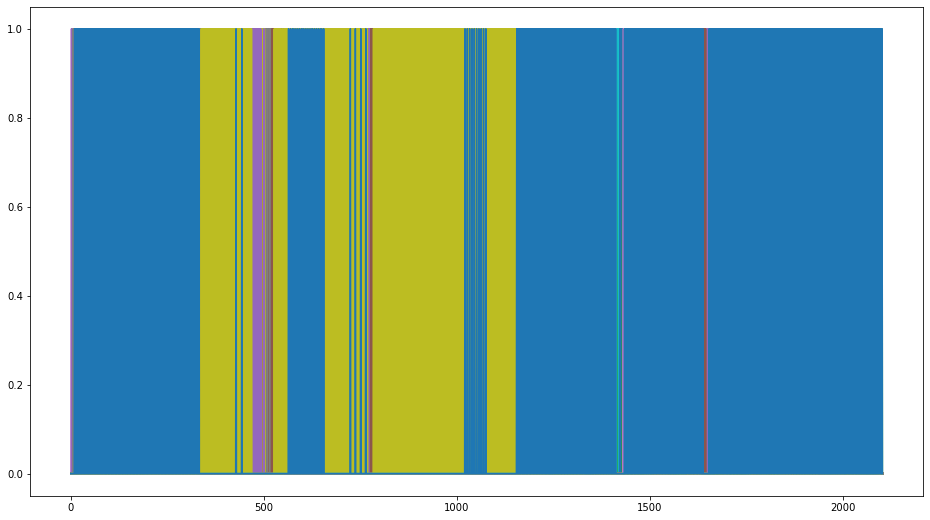

In [12]:
plt.figure(figsize=(16,9))
for i in range(neurons_in_time.shape[0]):
    plt.plot(neurons_in_time[i])

In [13]:
num = df.shape[1]
num_neurons = np.arange(0,num,1)
combi_neurons = list(itertools.combinations_with_replacement(num_neurons,2))
#combi_neurons

In [14]:
corr_u = np.zeros((len(combi_neurons),time_grid.shape[0]))
sc_corr_u = np.zeros((len(combi_neurons),time_grid.shape[0]))
corr_max_u = np.zeros(len(combi_neurons))
lag_u = np.zeros(len(combi_neurons))
thres_corr_u = np.zeros(len(combi_neurons))


for i in range(len(combi_neurons)):
    corr_u[i,:] = signal.correlate(neurons_in_time[combi_neurons[i][0]], neurons_in_time[combi_neurons[i][1]], mode='same', method='fft')
    one = signal.correlate(neurons_in_time[combi_neurons[i][0]], neurons_in_time[combi_neurons[i][0]], mode='same', method='fft')
    one_max = abs(one).max()
    two = signal.correlate(neurons_in_time[combi_neurons[i][1]], neurons_in_time[combi_neurons[i][1]], mode='same', method='fft')
    two_max = abs(two).max()
    sc_corr_u[i,:] = corr_u[i,:]/math.sqrt(one_max*two_max)
    lags = signal.correlation_lags(neurons_in_time[combi_neurons[i][0]].shape[0], neurons_in_time[combi_neurons[i][1]].shape[0], mode="full")
    lag_u[i] = lags[np.argmax(sc_corr_u[i,:])]
    corr_max_u[i] = abs(sc_corr_u[i,:]).max()
    
    #thres = 2/(np.sqrt(time_grid.shape[0]-abs(lag_u[i])))
    #if corr_max_u[i]>thres:
    #    thres_corr_u[i]=1

thres = 0.3
for i in range(len(combi_neurons)):
    if corr_max_u[i]>thres:
        thres_corr_u[i]=1

In [15]:
neurons_in_time[combi_neurons[2][1]].shape

(2103,)

In [16]:
n = int(np.sqrt(len(corr_max_u)*2))+1

idx = np.triu_indices(n, k=1, m=n)
matrix_u = np.zeros((n,n)).astype(float)
matrix_u[idx] = corr_max_u
matrix_u = np.delete(matrix_u, 0, 1)
matrix_u = np.delete(matrix_u, -1, 0)

# correlation matrix
print(matrix_u)

[[1.         0.45663896 0.45663896 ... 0.39588494 0.29611005 0.3141521 ]
 [0.         1.         0.57264957 ... 0.35071084 0.37133777 0.27169895]
 [0.         0.         1.         ... 0.34160146 0.22786636 0.258114  ]
 ...
 [0.         0.         0.         ... 1.         0.28783311 0.46513113]
 [0.         0.         0.         ... 0.         1.         0.29510933]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [17]:
#thres_corr_u

In [18]:
num = df.shape[1]
num_neurons = np.arange(0,num,1)
combi_neurons_no_replacement = list(itertools.combinations(num_neurons,2))
#combi_neurons_no_replacement

In [19]:
corr_l = np.zeros((len(combi_neurons_no_replacement),time_grid.shape[0]))
sc_corr_l = np.zeros((len(combi_neurons_no_replacement),time_grid.shape[0]))
corr_max_l = np.zeros(len(combi_neurons_no_replacement))
lag_l = np.zeros(len(combi_neurons_no_replacement))
thres_corr_l = np.zeros(len(combi_neurons_no_replacement))


for i in range(len(combi_neurons_no_replacement)):
    corr_l[i,:] = signal.correlate(neurons_in_time[combi_neurons_no_replacement[i][1]], neurons_in_time[combi_neurons_no_replacement[i][0]], mode='same', method='fft')
    one = signal.correlate(neurons_in_time[combi_neurons_no_replacement[i][0]], neurons_in_time[combi_neurons_no_replacement[i][0]], mode='same', method='fft')
    one_max = abs(one).max()
    two = signal.correlate(neurons_in_time[combi_neurons_no_replacement[i][1]], neurons_in_time[combi_neurons_no_replacement[i][1]], mode='same', method='fft')
    two_max = abs(two).max()
    sc_corr_l[i,:] = corr_l[i,:]/math.sqrt(one_max*two_max)
    lags = signal.correlation_lags(neurons_in_time[combi_neurons_no_replacement[i][1]].shape[0], neurons_in_time[combi_neurons_no_replacement[i][0]].shape[0], mode="full")
    lag_l[i] = lags[np.argmax(sc_corr_l[i,:])]
    corr_max_l[i] = abs(sc_corr_l[i,:]).max()
    
    #thres = 2/(np.sqrt(time_grid.shape[0]-abs(lag_l[i])))
    #if corr_max_l[i]>thres:
    #    thres_corr_l[i]=1

for i in range(len(combi_neurons_no_replacement)):
    if corr_max_l[i]>thres:
        thres_corr_l[i]=1

n = int(np.sqrt(len(corr_max_l)*2))+1
idx = np.tril_indices(n, k=-1, m=n)
matrix_l = np.zeros((n,n)).astype(float)
matrix_l[idx] = corr_max_l

# correlation matrix
print(matrix_l)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.45663896 0.         0.         ... 0.         0.         0.        ]
 [0.45663896 0.40218091 0.         ... 0.         0.         0.        ]
 ...
 [1.         1.         0.68599434 ... 0.         0.         0.        ]
 [0.20480696 0.13206309 0.1604816  ... 0.20076811 0.         0.        ]
 [0.16829272 0.17388062 0.19432996 ... 0.46513113 0.29510933 0.        ]]


In [20]:
# CORRELATION MATRIX
corr_mat = matrix_u + matrix_l
corr_mat

array([[1.        , 0.45663896, 0.45663896, ..., 0.39588494, 0.29611005,
        0.3141521 ],
       [0.45663896, 1.        , 0.57264957, ..., 0.35071084, 0.37133777,
        0.27169895],
       [0.45663896, 0.40218091, 1.        , ..., 0.34160146, 0.22786636,
        0.258114  ],
       ...,
       [1.        , 1.        , 0.68599434, ..., 1.        , 0.28783311,
        0.46513113],
       [0.20480696, 0.13206309, 0.1604816 , ..., 0.20076811, 1.        ,
        0.29510933],
       [0.16829272, 0.17388062, 0.19432996, ..., 0.46513113, 0.29510933,
        1.        ]])

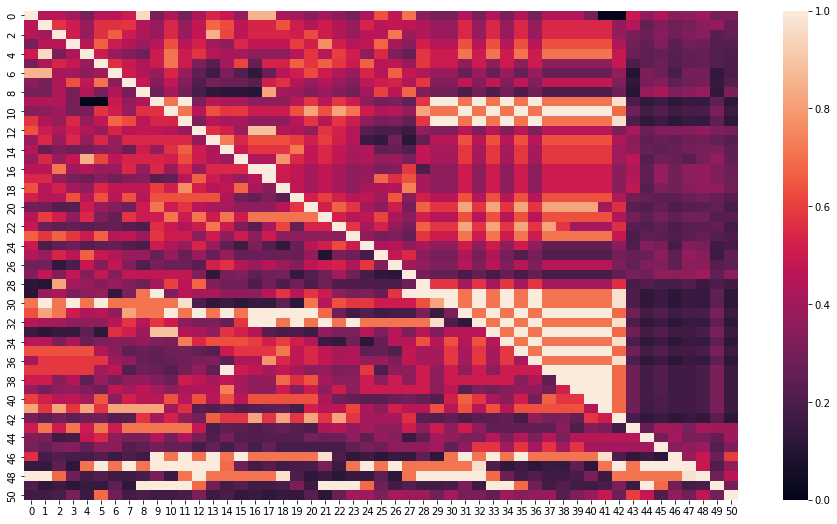

In [21]:
# heatmap of the cross correlation matrix
plt.figure(figsize=(16,9))
ax = sns.heatmap(corr_mat, annot = False, linewidths=0,vmin=0, vmax=1)
plt.savefig("51neuronsHeatmap.png")

In [22]:
# heatmap of the cross correlation but only the upper triangle
#mask = np.zeros_like(corr_mat)
#mask[np.tril_indices_from(mask)] = True
#with sns.axes_style("white"):
#    f, ax = plt.subplots(figsize=(16, 9))
#    ax = sns.heatmap(corr_mat, mask=mask, square=True, linewidths=0, vmin=0, vmax=1, annot = False)

In [23]:
n = int(np.sqrt(len(thres_corr_u)*2))+1

idx = np.triu_indices(n, k=1, m=n)
corr_matrix_u = np.zeros((n,n)).astype(float)
corr_matrix_u[idx] = thres_corr_u
corr_matrix_u = np.delete(corr_matrix_u, 0, 1)
corr_matrix_u = np.delete(corr_matrix_u, -1, 0)

n = int(np.sqrt(len(thres_corr_l)*2))+1

idx = np.tril_indices(n, k=-1, m=n)
corr_matrix_l = np.zeros((n,n)).astype(float)
corr_matrix_l[idx] = thres_corr_l

# threshold filtered correlation matrix
corr_mat_thres  = corr_matrix_u + corr_matrix_l
print(corr_mat_thres)

[[1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 0. 0.]
 ...
 [1. 1. 1. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]]


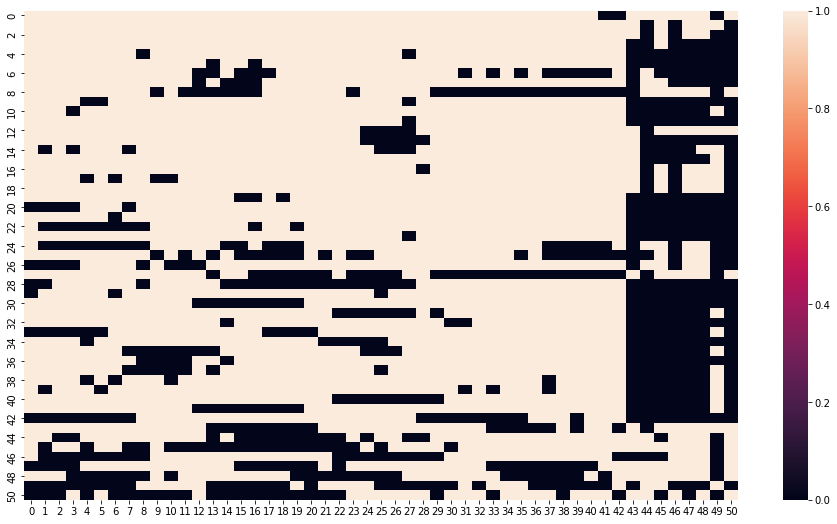

In [24]:
plt.figure(figsize=(16,9))
ax = sns.heatmap(corr_mat_thres, annot = False, linewidths=0,vmin=0, vmax=1)

In [25]:
# computing FFT
def fft_signal(array, sampling):
    
    Xf_mag = np.abs(np.fft.fft(array))
    freqs = np.fft.fftfreq(len(Xf_mag), d=1.0/sampling)    
    return freqs, Xf_mag

In [26]:
Sab_c_u = np.zeros((len(combi_neurons),time_grid.shape[0]))

for i in range(len(combi_neurons)):
    corr_U = signal.correlate(neurons_in_time[combi_neurons[i][0]], neurons_in_time[combi_neurons[i][1]], mode='same', method='fft')
    one = signal.correlate(neurons_in_time[combi_neurons[i][0]], neurons_in_time[combi_neurons[i][0]], mode='same', method='fft')
    one_max = abs(one).max()
    two = signal.correlate(neurons_in_time[combi_neurons[i][1]], neurons_in_time[combi_neurons[i][1]], mode='same', method='fft')
    two_max = abs(two).max()
    sc_corr_U = corr_U/math.sqrt(one_max*two_max)
       
    used_neuron = [combi_neurons[i][0], combi_neurons[i][1]]
    used_neuron = np.array(used_neuron)
    rem_neuron = num_neurons.tolist()
    
    if combi_neurons[i][0]==combi_neurons[i][1]:
        Sab_c_u[i,:] = 0
    
    else:
        for m in used_neuron:
            rem_neuron.remove(m)
        rem_neuron = np.array(rem_neuron)
    
        freq, mag = fft_signal(sc_corr_U,1000)
        Sab_c_u[i,:] = (mag**2)
    
        for j in range(rem_neuron.shape[0]):
            temp_corr1 = signal.correlate(neurons_in_time[combi_neurons[i][0]], neurons_in_time[j], mode='same', method='fft')
            temp_one1 = signal.correlate(neurons_in_time[combi_neurons[i][0]], neurons_in_time[combi_neurons[i][0]], mode='same', method='fft')
            temp_one_max1 = abs(temp_one1).max()
            temp_two1 = signal.correlate(neurons_in_time[j], neurons_in_time[j], mode='same', method='fft')
            temp_two_max1 = abs(temp_two1).max()
            sc_corr1 = temp_corr1/math.sqrt(temp_one_max1*temp_two_max1)
            _,mag1 = fft_signal(sc_corr1,1000)
        
            temp_corr2 = signal.correlate(neurons_in_time[j], neurons_in_time[combi_neurons[i][1]], mode='same', method='fft')
            temp_one2 = signal.correlate(neurons_in_time[combi_neurons[i][1]], neurons_in_time[combi_neurons[i][1]], mode='same', method='fft')
            temp_one_max2 = abs(temp_one2).max()
            temp_two2 = signal.correlate(neurons_in_time[j], neurons_in_time[j], mode='same', method='fft')
            temp_two_max2 = abs(temp_two2).max()
            sc_corr2 = temp_corr2/math.sqrt(temp_one_max2*temp_two_max2)
            _,mag2 = fft_signal(sc_corr2,1000)
        
            temp_corr3 = signal.correlate(neurons_in_time[j], neurons_in_time[j], mode='same', method='fft')
            temp_one3 = signal.correlate(neurons_in_time[j], neurons_in_time[j], mode='same', method='fft')
            temp_one_max3 = abs(temp_one3).max()
            temp_two3 = signal.correlate(neurons_in_time[j], neurons_in_time[j], mode='same', method='fft')
            temp_two_max3 = abs(temp_two3).max()
            sc_corr3 = temp_corr3/math.sqrt(temp_one_max3*temp_two_max3)
            _,mag3 = fft_signal(sc_corr3,1000)
        
            Sab_c_u[i,:] = Sab_c_u[i,:] - (mag1**2)*(mag**2)/(mag**3)

In [27]:
Sab_c_l = np.zeros((len(combi_neurons_no_replacement),time_grid.shape[0]))

for i in range(len(combi_neurons_no_replacement)):
    corr_L = signal.correlate(neurons_in_time[combi_neurons_no_replacement[i][1]], neurons_in_time[combi_neurons_no_replacement[i][0]], mode='same', method='fft')
    one = signal.correlate(neurons_in_time[combi_neurons_no_replacement[i][0]], neurons_in_time[combi_neurons_no_replacement[i][0]], mode='same', method='fft')
    one_max = abs(one).max()
    two = signal.correlate(neurons_in_time[combi_neurons_no_replacement[i][1]], neurons_in_time[combi_neurons_no_replacement[i][1]], mode='same', method='fft')
    two_max = abs(two).max()
    sc_corr_L = corr_L/math.sqrt(one_max*two_max)
       
    used_neuron = [combi_neurons_no_replacement[i][1], combi_neurons_no_replacement[i][0]]
    used_neuron = np.array(used_neuron)
    rem_neuron = num_neurons.tolist()
    for m in used_neuron:
        rem_neuron.remove(m)
    rem_neuron = np.array(rem_neuron)
    
    freq, mag = fft_signal(sc_corr_L,1000)
    Sab_c_l[i,:] = (mag**2)
    
    for j in range(rem_neuron.shape[0]):
        temp_corr1 = signal.correlate(neurons_in_time[combi_neurons_no_replacement[i][1]], neurons_in_time[j], mode='same', method='fft')
        temp_one1 = signal.correlate(neurons_in_time[combi_neurons_no_replacement[i][1]], neurons_in_time[combi_neurons_no_replacement[i][1]], mode='same', method='fft')
        temp_one_max1 = abs(temp_one1).max()
        temp_two1 = signal.correlate(neurons_in_time[j], neurons_in_time[j], mode='same', method='fft')
        temp_two_max1 = abs(temp_two1).max()
        sc_corr1 = temp_corr1/math.sqrt(temp_one_max1*temp_two_max1)
        _,mag1 = fft_signal(sc_corr1,1000)
        
        temp_corr2 = signal.correlate(neurons_in_time[j], neurons_in_time[combi_neurons_no_replacement[i][0]], mode='same', method='fft')
        temp_one2 = signal.correlate(neurons_in_time[combi_neurons_no_replacement[i][0]], neurons_in_time[combi_neurons_no_replacement[i][0]], mode='same', method='fft')
        temp_one_max2 = abs(temp_one2).max()
        temp_two2 = signal.correlate(neurons_in_time[j], neurons_in_time[j], mode='same', method='fft')
        temp_two_max2 = abs(temp_two2).max()
        sc_corr2 = temp_corr2/math.sqrt(temp_one_max2*temp_two_max2)
        _,mag2 = fft_signal(sc_corr2,1000)
        
        temp_corr3 = signal.correlate(neurons_in_time[j], neurons_in_time[j], mode='same', method='fft')
        temp_one3 = signal.correlate(neurons_in_time[j], neurons_in_time[j], mode='same', method='fft')
        temp_one_max3 = abs(temp_one3).max()
        temp_two3 = signal.correlate(neurons_in_time[j], neurons_in_time[j], mode='same', method='fft')
        temp_two_max3 = abs(temp_two3).max()
        sc_corr3 = temp_corr3/math.sqrt(temp_one_max3*temp_two_max3)
        _,mag3 = fft_signal(sc_corr3,1000)
        
        Sab_c_l[i,:] = Sab_c_l[i,:] - (mag1**2)*(mag**2)/(mag**3)

In [28]:
# Inverse fourier transform
corr_ab_c_u = np.zeros((len(combi_neurons),time_grid.shape[0]))
corr_ab_c_l = np.zeros((len(combi_neurons_no_replacement),time_grid.shape[0]))

for i in range(Sab_c_u.shape[0]):
    corr_ab_c_u[i,:] = np.fft.ifft(Sab_c_u[i,:])

for i in range(Sab_c_l.shape[0]):
    corr_ab_c_l[i,:] = np.fft.ifft(Sab_c_l[i,:])

In [29]:
# scaled correlation
scaled_corr_ab_c_u = np.zeros((len(combi_neurons),time_grid.shape[0]))
scaled_corr_ab_c_l = np.zeros((len(combi_neurons_no_replacement),time_grid.shape[0]))

for i in range(corr_ab_c_u.shape[0]):
    auto_corr1 = signal.correlate(neurons_in_time[combi_neurons[i][0]], neurons_in_time[combi_neurons[i][0]], mode='same', method='fft')
    auto_corr2 = signal.correlate(neurons_in_time[combi_neurons[i][1]], neurons_in_time[combi_neurons[i][1]], mode='same', method='fft')
    auto_corr_max1 = abs(auto_corr1).max()
    auto_corr_max2 = abs(auto_corr2).max()
    scaled_corr_ab_c_u[i,:] = corr_ab_c_u[i,:]/math.sqrt(auto_corr_max1*auto_corr_max2)

for i in range(corr_ab_c_l.shape[0]):
    auto_corr1 = signal.correlate(neurons_in_time[combi_neurons_no_replacement[i][0]], neurons_in_time[combi_neurons_no_replacement[i][0]], mode='same', method='fft')
    auto_corr2 = signal.correlate(neurons_in_time[combi_neurons_no_replacement[i][1]], neurons_in_time[combi_neurons_no_replacement[i][1]], mode='same', method='fft')
    auto_corr_max1 = abs(auto_corr1).max()
    auto_corr_max2 = abs(auto_corr2).max()
    scaled_corr_ab_c_l[i,:] = corr_ab_c_l[i,:]/math.sqrt(auto_corr_max1*auto_corr_max2)

In [30]:
def coin(array):
    array_near0 = array[array.shape[0]//2 - 25: array.shape[0]//2 + 25]
    area_near0 = trapz(array_near0, dx=1)
    area_whole = trapz(array, dx=1)

    coincidence = area_near0/area_whole
    return abs(coincidence)

In [31]:
# coincidence index
coindce_u = np.zeros(len(combi_neurons))
coindce_l = np.zeros(len(combi_neurons_no_replacement))
                     
for i in range(coindce_u.shape[0]):
    coindce_u[i] = coin(scaled_corr_ab_c_u[i,:])

coindce_u = np.nan_to_num(coindce_u, copy=True, nan=1)
    
for i in range(coindce_l.shape[0]):
    coindce_l[i] = coin(scaled_corr_ab_c_l[i,:])

In [32]:
n = int(np.sqrt(len(coindce_u)*2))+1
idx = np.triu_indices(n, k=1, m=n)
matrix_u = np.zeros((n,n)).astype(float)
matrix_u[idx] = coindce_u
matrix_u = np.delete(matrix_u, 0, 1)
matrix_u = np.delete(matrix_u, -1, 0)


n = int(np.sqrt(len(coindce_l)*2))+1
idx = np.tril_indices(n, k=-1, m=n)
matrix_l = np.zeros((n,n)).astype(float)
matrix_l[idx] = coindce_l

coin_mat = matrix_u + matrix_l

In [33]:
coin_mat_bool = coin_mat.copy()

In [34]:
for i in range(coin_mat.shape[0]):
    for j in range(coin_mat.shape[1]):
        
        if coin_mat[i,j]>=coin_mat[j][i]:
            coin_mat[j][i]=0
            coin_mat[i,j]=1*coin_mat[i,j]
            coin_mat_bool[j][i]=0
            coin_mat_bool[i,j]=1
        else:
            coin_mat[i,j]=0
            coin_mat[j][i]=1*coin_mat[j][i]
            coin_mat_bool[i,j]=0
            coin_mat_bool[j][i]=1

            
for i in range(coin_mat.shape[0]):
    for j in range(coin_mat.shape[1]):
        
        if coin_mat[i,j]!=0 and corr_mat_thres[i][j]==1:
            coin_mat_bool[i][j]=1
            coin_mat[i][j]=1*coin_mat[i][j]
        else:
            coin_mat_bool[i][j]=0
            coin_mat[i][j]=0
        
    coin_mat[i][i]=0
    coin_mat_bool[i][i]=0

In [35]:
print(np.max(coin_mat),np.min(coin_mat))
print(np.mean(coin_mat))
print(np.std(coin_mat))

395.67245912144864 0.0
0.4131269077937504
9.522589142359697


In [36]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

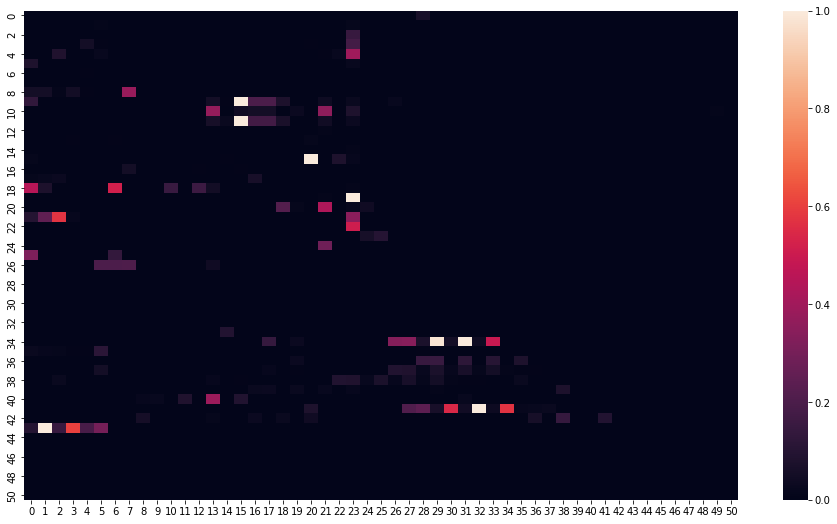

In [37]:
plt.figure(figsize=(16,9))
coin_mat_scaled = coin_mat.copy()
coin_mat_scaled = (coin_mat_scaled - np.mean(coin_mat_scaled)) / np.std(coin_mat_scaled)
ax = sns.heatmap(coin_mat_scaled, annot = False, linewidths=0, vmin=-0, vmax=1)

In [38]:
print(np.min(coin_mat_scaled))
print(np.std(coin_mat_scaled))
print(np.max(coin_mat_scaled))

-0.043383884531573685
0.9999999999999998
41.50754866188731


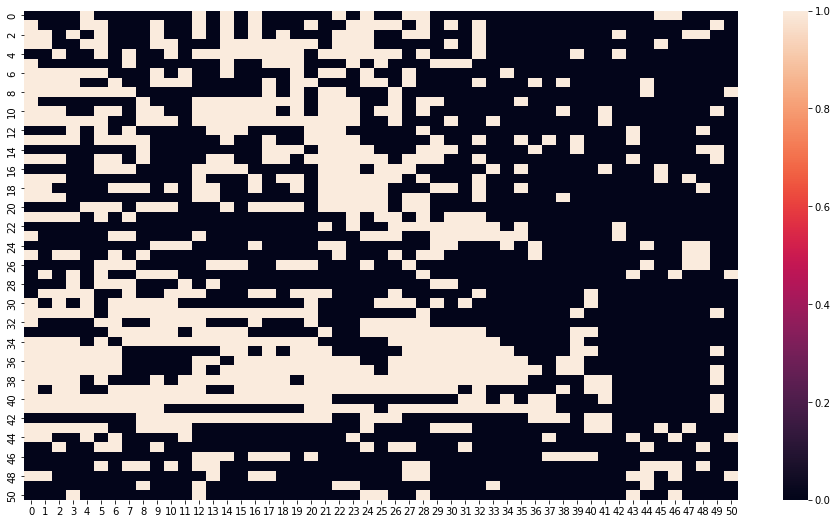

In [39]:
plt.figure(figsize=(16,9))
ax = sns.heatmap(coin_mat_bool, annot = False, linewidths=0, vmin=-0,vmax=1)

In [40]:
import math
pi = math.pi

def getPoints(N):
    r = 0.25
    center = [0.5, 0.5]
    return [(math.cos(2*pi/N*(x))*r + center[0], math.sin(2*pi/N*(x))*r + center[1]) for x in range(0,N)]

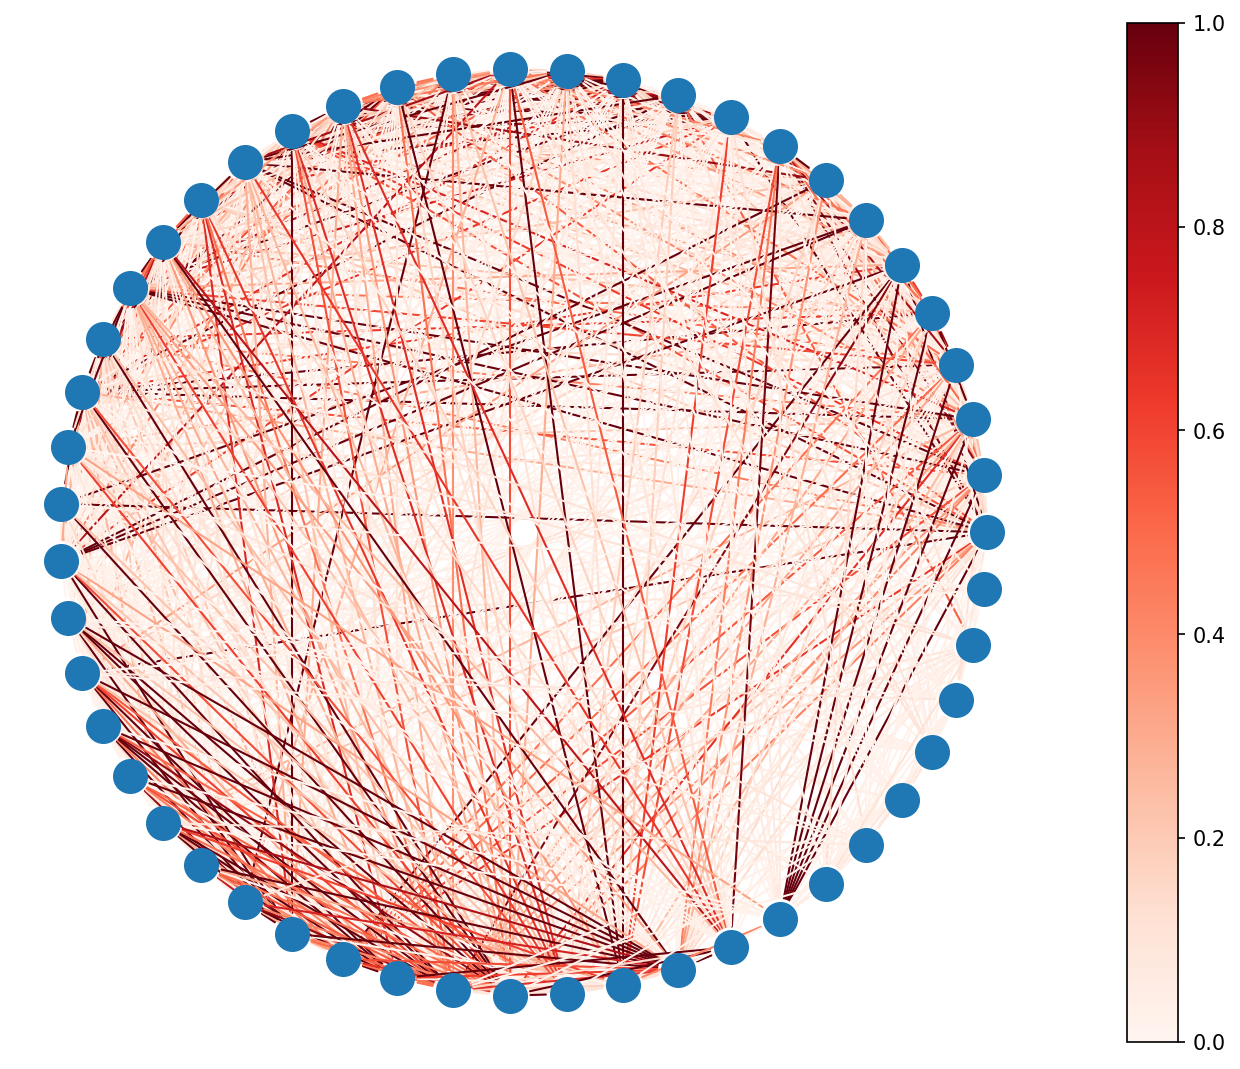

In [48]:
# draw graph
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

fig = plt.figure(figsize=(16, 9), dpi=150)

# N = 50 # number of neurons
# connections = np.random.rand(N, N)
# connections = connections.round()

connections = coin_mat_bool
np.save("connections.csv", connections)
weights = coin_mat
colors = plt.cm.get_cmap('Reds')
weight_colors = colors(weights)

N = coin_mat_bool.shape[0]

# get N points on circle with some radius
coords = getPoints(N)
coords = np.array(coords)
marker_area = 250
marker_radius = np.sqrt(marker_area)
plt.scatter(coords[:,0], coords[:,1], s=marker_area, zorder=2) # some hardcoded marker size
plt.gca().set_aspect('equal')
plt.axis('off')

# label neurons

labels = []
for n in range(N):
    labels.append(str(n))

#plt.gca().annotate(labels[0], coords[0], xytext=[0, 0])

# draw connections
for i in range(connections.shape[0]): # rows
    for j in range(connections.shape[1]): # columns
        if (i == j):
            continue
        if (connections[i, j] == 1):        
            start = (coords[i, 0], coords[i, 1])
            end = (coords[j, 0], coords[j, 1])
            plt.gca().add_artist(ConnectionPatch(start, end, "data", "data", arrowstyle = "-", \
                mutation_scale=20, shrinkA=10, shrinkB=10, fc='w', connectionstyle='arc',\
                    color=weight_colors[i,j], zorder=1))

cbar = plt.colorbar(orientation='vertical')
plt.set_cmap('Reds')

plt.savefig("Connectivity.png")
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34] [35 36 37 38 39 40 41 42 43 44 45 46 47] [48 49 50]


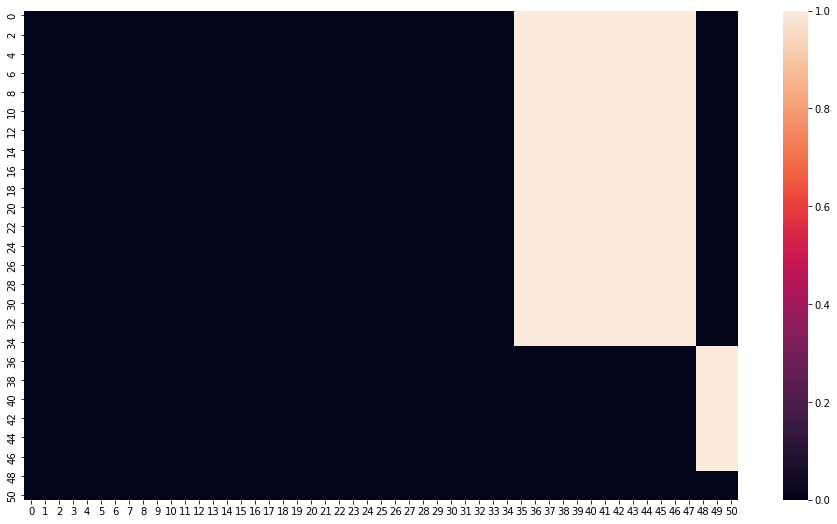

In [77]:
# Ground truth connectivity:
input_indeces = [138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]
num_input = len(input_indeces)
input_linear = np.arange(0, num_input)
hidden_indeces = np.arange(180, 193, 1)
hidden_linear = np.arange(num_input, num_input + len(hidden_indeces))
output_indeces = [194, 195, 196]
output_linear = np.arange(num_input + len(hidden_indeces), num_input + len(hidden_indeces) + 3)

print(input_linear, hidden_linear, output_linear)

connectivity_truth = np.zeros(coin_mat_bool.shape)

for row in range(connectivity_truth.shape[0]):
    for col in range(connectivity_truth.shape[1]):
        if (col < row): 
            continue
        elif (row == col):
            connectivity_truth[row, col] = 0
        elif (row <= input_linear[-1] and (col >= hidden_linear[0] and col <= hidden_linear[-1])): # input neuron
            connectivity_truth[row, col] = 1

for i in hidden_linear:
    connectivity_truth[i, output_linear] = 1


plt.figure(figsize=(16,9))
ax = sns.heatmap(connectivity_truth, annot = False, linewidths=0, vmin=-0,vmax=1)
plt.savefig("groundTruthConnections.png")
